## Example usage of the Vision Automatic Band Gap Extractor package
<img src="./HS/auto_bandgap_extraction_R1.png"
     align="Top" 
     width="500" />
     
     
By leveraging hyperspectral imaging and computer vision segmentation, the computation of band
gap is parallelized across batches of HT-manufactured materials. The figure above illustrates the process of first extracting the reflectance hypercube from each vision-segmented deposit, then transforming the reflectance to its Tauc plot using Equation 2, and finally recursively segmenting the Tauc plot into linear segments (R2 ≥ 0.990) to find the line of best fit, which determines band gap. 

#### The input hyperspectral datacube .bil and .hdr files are segmented and then band gaps are automatically calculated across all segmented samples.

In [1]:
# imports for band gap extraction
import vision
import bandextractor
import compextractorb
import os
import requests
# imports for visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

#### Download the Hyperspectral data and Read Motor Speed and Gcode Files 

Example **.bil** and **.hdr** hypercubes of the printed FA$_{1-x}$MA$_x$PbI$_3$ semiconductors from this study will be made publicly available.

In [2]:
# Download data from OSF database
bandextractor.download(url='https://osf.io/download/aebuq',filename='FAMAPbI.hdr')
bandextractor.download(url='https://osf.io/download/27h3e',filename='FAMAPbI.bil')

bil = 'data/FAMAPbI.bil'
hdr = 'data/FAMAPbI.hdr'

# Read motor speed and gcode files used for composition extraction 
datapath = os.getcwd() 
with open(datapath+'/data/motor_speeds.txt', 'r') as file:
    motor_speeds = file.read()
gcode = pd.read_csv(os.getcwd()+'/data/gcode_XY.csv')

data/MAFAPbI.hdr downloaded: 0.003 MB
data/MAFAPbI.bil downloaded: 843.750 MB


#### Define crop parameters to segment the hyperspectral datacube
rotate_crop_params = a set of parameters for croping out the background of the sample image and focusing on the samples  

In [9]:
# Variables
rotate_crop_params = {
    'theta': 1, # Image rotation angle
    'x1': 55, # left x bound 
    'x2': 870, # Right x bound 
    'y1': 270, # Top y bound 
    'y2': 720 # Bottom y bound 
} # USER DEFINED ROTATE/CROP PARAMETERS

#### Segment the droplets 
Use the watershed algorithm to segment and label each droplet in the sample image 

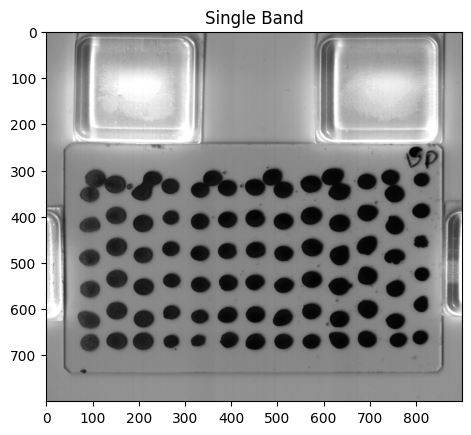

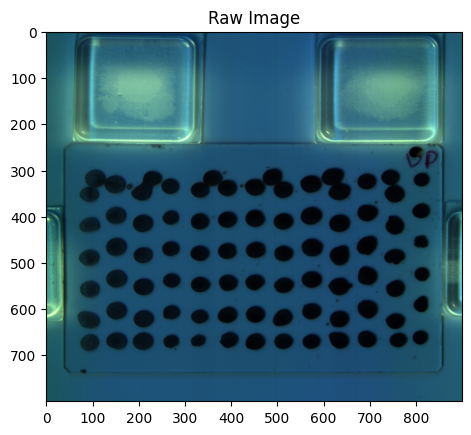

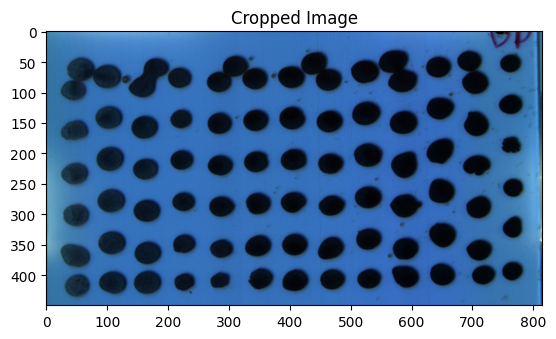

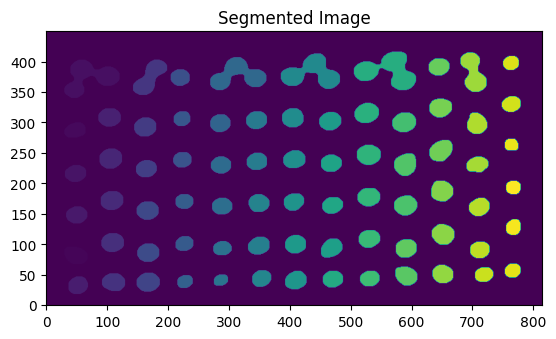

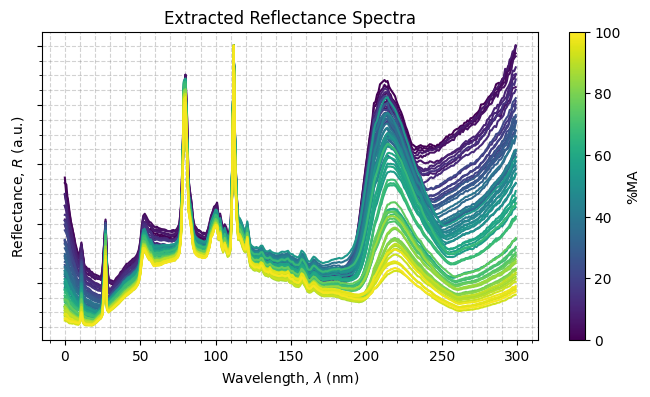

In [10]:
data, sgmnt = vision.segmentation(bil=bil, hdr=hdr, rotate_crop_params=rotate_crop_params, savepath=f'{datapath}/Bandgap/', return_segment = True)

#### Extract composition of segmented data using motor speeds and gcode
For accurate composition extraction, the raster patterns must be lined up with the droplet locations. Changing compextractor_params shifts the location of the raster pattern in order to align it with the droplets. 

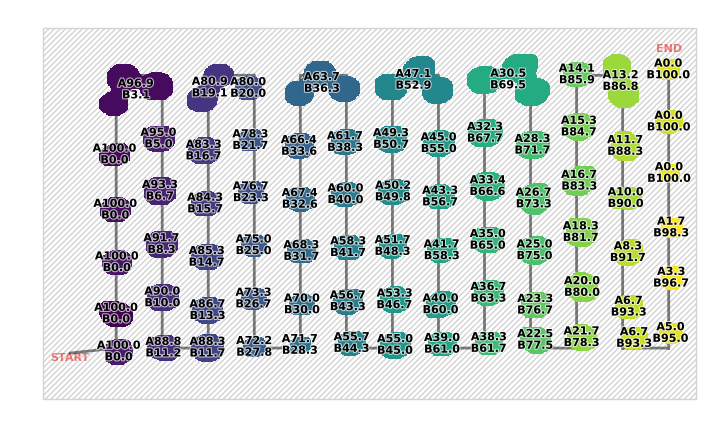

In [26]:
compextractor_params = {
    'rasterSpeed' : 38, # mm/s gocde raster speed
    'rasterScaleY' : 0.8, # scale gcode raster pattern in Y-dim
    'rasterScaleX' : 0.95, # scale gcode raster pattern in X-dim
    'rasterOffsetY' : 30, # offset gcode raster pattern in X-dim
    'rasterOffsetX' : -10 # offset gcode raster pattern in X-dim
}
idx, comp, vals = compextractorb.get_compositions(data, segmentation=sgmnt, motor_speeds=motor_speeds, gcode=gcode, rasterSpeed=compextractor_params['rasterSpeed'], rasterScaleY=compextractor_params['rasterScaleY'], rasterScaleX=compextractor_params['rasterScaleX'], rasterOffsetX=compextractor_params['rasterOffsetX'], rasterOffsetY=compextractor_params['rasterOffsetY'], savepath=f'{datapath}/Bandgap/')

#### Run band gap extractor

In [27]:
# run band gap extractor
egs = bandextractor.autoextract_direct(data=vals, savepath=f'{datapath}/Bandgap/', verbose=False)
# Create x and Y Vectors to Plot the Band Gaps 
x, y = bandextractor.mapping(comp,egs)

#### Plot Extracted Band Gaps and Save it along with the Sorted Raw Spectra as csv 

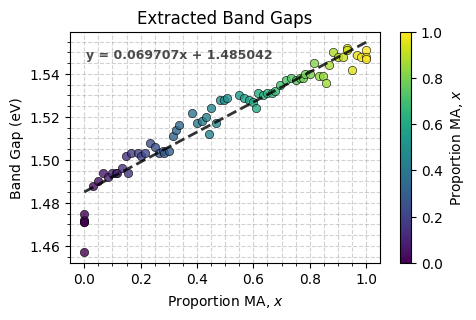

In [28]:
# plot the extracted band gaps
bandextractor.plot_ev(x,y,datapath)
# save sorted raw spectra as csv
bandextractor.save_csv(comp,vals,datapath)